# Valuation of IVU Traffic Technologies AG

This notebook attempts a layman valuation of the German company "IVU Traffic Technologies AG".

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot
matplotlib.style.use('ggplot')
matplotlib.rcParams.update({'font.size': 18, 'figure.facecolor': '1', 'figure.figsize': (10, 4)})

First, let's load some of the data from the company's quarterly reports. Because parsing PDFs is annoying, I already converted it into a CSV file:

In [2]:
df = pd.read_csv('IVU/IVU_Reports_Data.csv')
del df['Company']
df = df.set_index(["Year", "Quarter"])
df *= 1000 # each value in the CSV file is in thousand €, so lets multiply by thousand to get the € values
df

Revenue  GrossProfit  StaffExpenditures     EBIT  NetProfit
Year Quarter                                                              
2014 Q4       47200000     37100000           23900000  4300000    4400000
2015 Q1        9361000      7335000            6316000  -786000    -855000
     Q2       21458000     15674000           12720000  -914000   -1186000
     Q3       33453000     24173000           18130000   -66000    -721000
     Q4       58100000     40100000           25200000  4900000    3600000
2016 Q1        9761000      7387000            7134000 -1812000   -2419000
     Q2       22771000     17494000           14517000 -1586000   -2244000
     Q3       37292000     27398000           20613000 -1902000   -2854000
     Q4       59800000     42800000           28600000  1400000    -200000
2017 Q1       11572000      8945000            7380000  -679000    -920000
     Q2       26153000     19239000           15064000  -592000   -1085000
     Q3       40756000     29303000           22362000    65000    -493000
     Q4       71100000     47700000           31200000  6100000    5000000
2018 Q1       13993000      9695000            8261000  -684000    -837000
     Q2       29965000     20673000           16771000  -625000    -911000
     Q3       51932000     35317000           24772000  3149000    2731000

Now, to get a feel for this dataset, let's plot it:

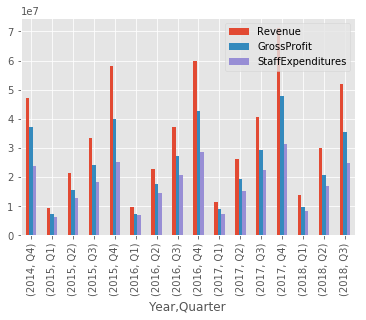

In [3]:
df[["Revenue", "GrossProfit", "StaffExpenditures"]].plot(kind='bar');

Why the wild cyclical swings? This is because in IVU's reports, data points like revenue are accumulated for the year to date. So Q2 will contain values for January to June.

As the next part of our data processing, we will try to get the actual offsets for each quarter:

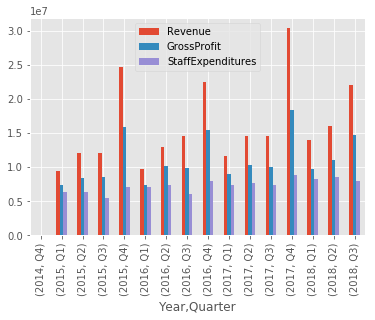

In [4]:
df_quarterly = df[["Revenue", "GrossProfit", "StaffExpenditures"]].copy(deep=True)
for (qs, qd) in (('Q3', 'Q4'), ('Q2', 'Q3'), ('Q1', 'Q2')):
    subq = df_quarterly.loc[pd.IndexSlice[:,[qs]], :]
    subq.index = subq.index.droplevel(1)
    df_quarterly.loc[pd.IndexSlice[:,[qd]], :] -= subq
df_quarterly.plot(kind='bar');

## Prediction (Linear model)

We can now go ahead and try to predict the Q4 2018 values. Our first attempt will be fitting a two-variable linear model ("Year" being the first, "Quarter" being the second).

In [5]:
import sklearn.linear_model
import sklearn
from sklearn_pandas import DataFrameMapper, cross_val_score

cols = df.columns[1:]
std_scaler = sklearn.preprocessing.StandardScaler()
mapper = DataFrameMapper([(cols, std_scaler)])

def map_index_to_int(df):
    df_index = df.copy()
    df_index.index = pd.MultiIndex.from_tuples([(year, int(quarter[1])) for (year, quarter) in df.index], names=["Year", "Quarter"])
    return df_index

def map_index_to_str(df):
    df_index = df.copy()
    df_index.index = pd.MultiIndex.from_tuples([(year, 'Q{0}'.format(quarter)) for (year, quarter) in df.index], names=["Year", "Quarter"])
    return df_index

In [6]:
df_index = map_index_to_int(df)
lm = sklearn.linear_model.LinearRegression()
lm.fit(np.array(list(df_index.index)), mapper.fit_transform(df_index.copy()));
predict_quarters = [[year, quarter] for year in (2016, 2017, 2018, 2019) for quarter in (1,2,3,4)]

prediction = lm.predict(np.array(predict_quarters))

predict_df = pd.DataFrame(std_scaler.inverse_transform(prediction))
predict_df = predict_df.rename({i: col for i, col in enumerate(cols)}, axis='columns')
predict_df.index = pd.MultiIndex.from_tuples(predict_quarters, names=["Year", "Quarter"])

final_df = pd.concat([map_index_to_str(predict_df).add_prefix("Pred_"), df], axis=1)                      

/home/hannes/projects/iconomi-analysis/venv/lib/python3.7/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/hannes/projects/iconomi-analysis/venv/lib/python3.7/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


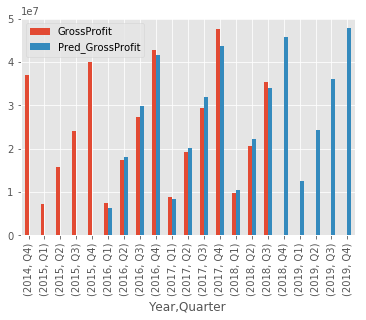

In [7]:
final_df[["GrossProfit", "Pred_GrossProfit"]].plot(kind='bar')

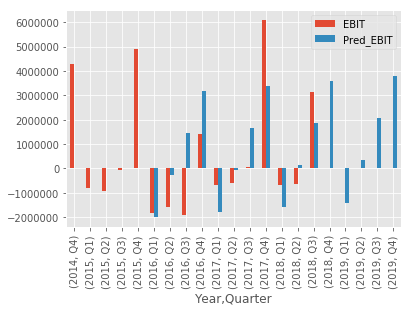

In [8]:
final_df[["EBIT", "Pred_EBIT"]].plot(kind='bar')

The numbers predicted by the linear model for the gross profit are looking ok, while the EBIT is not accurately depicted. A linear model is obviously not sufficient to fit the data.

Nevertheless, let's see what exact numbers are predicted for Q4 2018. When the earnings report is released, we will compare the numbers and then improve our methodology with a non-linear model.

In [9]:
final_df.loc[(2018, "Q4")]

Pred_GrossProfit          4.573414e+07
Pred_StaffExpenditures    3.126298e+07
Pred_EBIT                 3.599998e+06
Pred_NetProfit            2.555915e+06
Revenue                            NaN
GrossProfit                        NaN
StaffExpenditures                  NaN
EBIT                               NaN
NetProfit                          NaN
Name: (2018, Q4), dtype: float64

## Tapping into the EBIT Multiple Valuation Method

Using this prediction, we can attempt a cashflow-based valuation. Let's define some variables that we need later:

In [10]:
SHARES_OUTSTANDING = 17_720_000

Next we can take the predicted EBIT (or take the average of the last three years), and multiply it by 8 to get a rough estimate of the companies value. Divided by the shares outstanding, we should get a fair share price:

In [11]:
final_df.loc[(2018, "Q4")].Pred_EBIT * 8 / SHARES_OUTSTANDING

1.6252811022616118

In [12]:
final_df[final_df.index.get_level_values(1) == 'Q4'].EBIT.mean() * 8 / SHARES_OUTSTANDING

1.8848758465011286

These values are at least in the ballpark of the current share price (~5 €). But, this is still a very crude simplification, and it ignores the assets of the company. Next up, we will refine the valuation using a techique similar to the one described in https://www.oldschoolvalue.com/blog/valuation-methods/ebit-multiple-valuation/. Stay tuned!